In [12]:
import Environment
import Shop
from mab.ucb_learner import *
from utilities import *

In [18]:
shop_small_ts = Shop.Shop()
shop_ucb = Shop.Shop()

# shop_ts = Shop.Shop()
# shop_big_ts = Shop.Shop()
shop_clairvoyant = Shop.Shop()

env = Environment.Environment(shop_small_ts.prices1, shop_small_ts.prices2, shop_small_ts.discounts)

shop_small_ts.set_conv_rate(env.true_conv1, env.true_conv2)
shop_ucb.set_conv_rate(env.true_conv1, env.true_conv2)

# shop_ts.set_conv_rate(env.true_conv1, env.true_conv2)
# shop_big_ts.set_conv_rate(env.true_conv1, env.true_conv2)
# shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)


price_arms = [(i, j) for i in range(len(shop_small_ts.prices1)) for j in range(len(shop_small_ts.prices2))]
n_price_arms = len(price_arms)

# matching_arms = [(i, j, k, l) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2)) for k in range(shop_ts.n_classes) for l in range(len(shop_ts.discounts))]
# n_matching_arms = len(matching_arms)

small_matching_arms = [(i, j) for i in range(shop_small_ts.n_classes) for j in range(len(shop_small_ts.discounts))]
small_n_matching_arms = len(small_matching_arms)

shop_small_ts.set_assignment_learner('TS', small_n_matching_arms)
shop_ucb.set_assignment_learner('UCB', small_n_matching_arms)

shop_small_ts.set_price_learner('TS', 5)
shop_ucb.set_price_learner('UCB', 5)

shop_small_ts.set_price2_learner('TS', 5)
shop_ucb.set_price2_learner('UCB', 5)

# shop_ts.set_price_learner('TS', n_price_arms)
# shop_ts.set_assignment_learner('TS', n_matching_arms)


# shop_big_ts.set_assignment_learner('TS', n_matching_arms)

In [19]:
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])
max_ind_reward = max(env.prices1) + max(env.prices2)

In [20]:
#### get clairvoyant price
expected_rewards = np.zeros((5,5)) # price1*price2
shop_clairvoyant.set_expected_customers(np.array([25, 25, 25, 25]))
customers_mean = np.array([25, 25, 25, 25])

##### other way to calculate clairvoyant
cec = shop_clairvoyant.get_customer_list()
cep = shop_clairvoyant.get_promo_list(generated_promo_ratios)

cmt, cpa, cer, ers  = shop_clairvoyant.get_clairvoyant_prices_and_matching(cec, cep, 5, 5)

cp1idx = price_arms[cpa][0]
cp2idx = price_arms[cpa][1]
cp1 = env.prices1[cp1idx]
cp2 = env.prices2[cp2idx]

cpf = shop_clairvoyant.get_promo_fractions_from_tuples(cmt)

print(cpf)
print(cp1)
print(cp2)
print(cer)

[[0.6 0.  0.  0.4]
 [0.  0.  0.8 0.2]
 [1.  0.  0.  0. ]
 [0.  1.  0.  0. ]]
120.0
200.0
16284.660412472065


In [21]:
days = 365

calt_rewards_per_class_per_day = []

for day in range(days):
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)


    revenue_calt = []

    for cust in customers:

        selected_promo_calt = np.random.choice([0, 1, 2, 3], 1, p=cpf[cust])

        calt_buy1 = env.round1(cust, cp1)
        calt_buy2 = 0
        if calt_buy1:
            calt_buy2 = env.round2(cust, selected_promo_calt, cp2)


        calt_ind_reward = calt_buy1*cp1 + calt_buy2*cp2*(1-shop_small_ts.discounts[selected_promo_calt])


        revenue_calt.append(calt_ind_reward)

    calt_rewards_per_class_per_day.append(np.mean(revenue_calt))        

In [22]:
days = 365

u_rewards_per_class_per_day = []
small_ts_rewards_per_class_per_day = []

# ts_rewards_per_class_per_day = []
# big_ts_rewards_per_class_per_day = []
# calt_rewards_per_class_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

for day in range(days):
    if day == 0:
        # shop_ts.set_expected_customers(customers_ie)
        # shop_big_ts.set_expected_customers(customers_ie)

        shop_ucb.set_expected_customers(customers_ie)
        shop_small_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_small_ts.set_expected_customers((customers_em + 0.99).astype(int))
        # shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
        # shop_big_ts.set_expected_customers((customers_em + 0.99).astype(int))
    
    # # select the price for 2 step learner
    # chosen_price_tuple_idx_ts = shop_ts.price_learner.pull_arm()

    # price1idx_ts = price_arms[chosen_price_tuple_idx_ts][0]
    # price2idx_ts = price_arms[chosen_price_tuple_idx_ts][1]
    # price1_ts = env.prices1[price_arms[chosen_price_tuple_idx_ts][0]]
    # price2_ts = env.prices2[price_arms[chosen_price_tuple_idx_ts][1]]

    # # perform matching and get promo fractions for 2 step learner
    # expected_customers_ts = shop_ts.get_customer_list()
    # expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios)
    # matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, matching_arms, price1idx_ts, price2idx_ts)
    # promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)

    # # get promo fractions and prices for big learner
    # expected_customers_big_ts = shop_big_ts.get_customer_list()
    # expected_promos_big_ts = shop_big_ts.get_promo_list(generated_promo_ratios)
    # matched_tuples_big_ts, price_arm_index_big_ts = shop_big_ts.assignment_learner.pull_arm_all(expected_customers_big_ts, expected_promos_big_ts, matching_arms, len(env.prices1), len(env.prices2))
    # promo_fractions_big_ts = shop_big_ts.get_promo_fractions_from_tuples(matched_tuples_big_ts)

    # price1idx_big_ts = price_arms[price_arm_index_big_ts][0]
    # price2idx_big_ts = price_arms[price_arm_index_big_ts][1]
    # price1_big_ts = env.prices1[price1idx_big_ts]
    # price2_big_ts = env.prices2[price2idx_big_ts]

    # get expected list of customers
    expected_customers_u = shop_ucb.get_customer_list()
    expected_customers_small_ts = shop_small_ts.get_customer_list()

    # get expected list of promos
    expected_promos_u = shop_ucb.get_promo_list(generated_promo_ratios) 
    expected_promos_small_ts = shop_small_ts.get_promo_list(generated_promo_ratios) 

    #Pull arm price1 from learners 
    chosen_price1_small_ts = shop_small_ts.price_learner.pull_arm()
    chosen_price1_ucb = shop_ucb.price_learner.pull_arm() 

    #Pull arm price2 from learners 
    chosen_price2_small_ts = shop_small_ts.price2_learner.pull_arm()
    chosen_price2_ucb = shop_ucb.price2_learner.pull_arm() 
    

    # generate the connections and their expected weights
    matched_tuples_u = shop_ucb.assignment_learner.pull_arm_matching(expected_customers_u, expected_promos_u, matching_arms)
    matched_tuples_small_ts = shop_small_ts.assignment_learner.pull_arm_matching(expected_customers_small_ts, expected_promos_small_ts, matching_arms)
 
    promo_fractions_u = shop_ucb.get_promo_fractions_from_tuples(matched_tuples_u)
    promo_fractions_small_ts = shop_small_ts.get_promo_fractions_from_tuples(matched_tuples_small_ts)

    # simulate the day
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_small_ts = []
    revenue_ucb = []
    # revenue_ts = []
    # revenue_big_ts = []
    revenue_calt = []

    small_ts_total_reward = 0
    ucb_total_reward = 0
    # big_ts_total_reward = 0
    # ts_total_reward = 0
    calt_total_reward = 0

    c_count = 0

    for cust in customers:
        ts_ind_reward = 0

        selected_promo_small_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_small_ts[cust])
        selected_promo_u = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_u[cust])
        #selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        #selected_promo_big_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_big_ts[cust])
        selected_promo_calt = np.random.choice([0, 1, 2, 3], 1, p=cpf[cust])

        small_ts_buy1 = env.round1(cust, chosen_price1_small_ts)
        small_ts_buy2 = 0
        if small_ts_buy1:
            small_ts_buy2 = env.round2(cust, selected_promo_small_ts, chosen_price2_small_ts)
        
        u_buy1 = env.round1(cust, chosen_price1_ucb)
        u_buy2 = 0
        if u_buy1:
            u_buy2 = env.round2(cust, selected_promo_u, chosen_price2_ucb)

        # ts_buy1 = env.round1(cust, price1_ts)
        # ts_buy2 = 0
        # if ts_buy1:
        #     ts_buy2 = env.round2(cust, selected_promo_ts, price2_ts)

        # big_ts_buy1 = env.round1(cust, price1_big_ts)
        # big_ts_buy2 = 0
        # if big_ts_buy1:
        #     big_ts_buy2 = env.round2(cust, selected_promo_big_ts, price2_big_ts)


        calt_buy1 = env.round1(cust, cp1)
        calt_buy2 = 0
        if calt_buy1:
            calt_buy2 = env.round2(cust, selected_promo_calt, cp2)
        
        small_ts_ind_reward= small_ts_buy1*chosen_price1_small_ts + small_ts_buy2*chosen_price2_small_ts*(1-shop_small_ts.discounts[selected_promo_small_ts])
        u_ind_reward = u_buy1*chosen_price1_ucb + u_buy2*chosen_price2_ucb*(1-shop_ucb.discounts[selected_promo_u])
        # ts_ind_reward = ts_buy1*price1_ts + ts_buy2*price2_ts*(1-shop_ts.discounts[selected_promo_ts])
        # big_ts_ind_reward = big_ts_buy1*price1_big_ts + big_ts_buy2*price2_big_ts*(1-shop_big_ts.discounts[selected_promo_big_ts])
        calt_ind_reward = calt_buy1*cp1 + calt_buy2*cp2*(1-shop_small_ts.discounts[selected_promo_calt])
        
        norm_small_ts_ind_reward = small_ts_ind_reward / max_ind_reward
        norm_u_ind_reward = u_ind_reward / max_ind_reward
        # norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        # norm_big_ts_ind_reward = big_ts_ind_reward / max_ind_reward

        # update price learner and assignment learner
        shop_ucb.assignment_learner.update(matching_arms.index((cust, selected_promo_u), norm_u_ind_reward))
        shop_small_ts.assignment_learner.update(matching_arms.index((cust, selected_promo_small_ts)), norm_small_ts_ind_reward)
        # shop_ts.price_learner.update(chosen_price_tuple_idx_ts, norm_ts_ind_reward)

        # matching_arm_index_ts = matching_arms.index((price1idx_ts, price2idx_ts, cust, selected_promo_ts))
        # shop_ts.assignment_learner.update(matching_arm_index_ts, norm_ts_ind_reward)

        # # buradaki matching arm index sadece price ikilisini veriyor
        # matching_arm_index_big_ts = matching_arms.index((price1idx_big_ts, price2idx_big_ts, cust, selected_promo_big_ts))
        # shop_big_ts.assignment_learner.update(matching_arm_index_big_ts, norm_big_ts_ind_reward)

        revenue_ucb.append(ts_ind_reward)
        revenue_small_ts.append(ts_ind_reward)
        # revenue_ts.append(ts_ind_reward)
        # revenue_big_ts.append(big_ts_ind_reward)
        revenue_calt.append(calt_ind_reward)

    small_ts_rewards_per_class_per_day.append(np.mean(revenue_small_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    # ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    # big_ts_rewards_per_class_per_day.append(np.mean(revenue_big_ts))
    calt_rewards_per_class_per_day.append(np.mean(revenue_calt))

ValueError: (0, 0) is not in list

In [17]:
print(np.cumsum(calt_rewards_per_class_per_day)[-1] - np.cumsum(small_ts_rewards_per_class_per_day)[-1])
print(np.cumsum(calt_rewards_per_class_per_day)[-1] - np.cumsum(u_rewards_per_class_per_day)[-1])

5024.347016654981
10931.817245503255


Text(0, 0.5, 'Revenue')

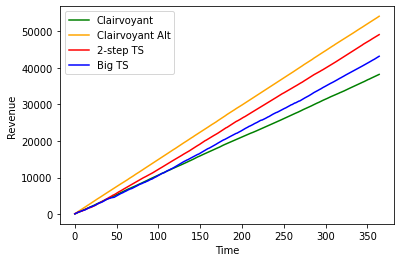

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(u_rewards_per_class_per_day), color='green', label='UCB')
plt.plot(np.cumsum(calt_rewards_per_class_per_day), color='orange', label='Clairvoyant Alt')
plt.plot(np.cumsum(small_ts_rewards_per_class_per_day), color='orange', label='3-Learner TS')
# plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='2-step TS')
# plt.plot(np.cumsum(big_ts_rewards_per_class_per_day), color='blue', label='Big TS')
#plt.plot(np.cumsum(c_expected_per_day), color='black', label='Expected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

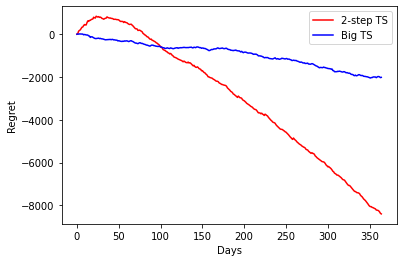

In [9]:
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='2-step TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(big_ts_rewards_per_class_per_day)), color='blue', label='Big TS')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')

In [14]:
matching_arms

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (0, 4, 0, 0),
 (0, 4, 0, 1),
 (0, 4, 0,

In [7]:
cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(-cost)
cost[row_ind, col_ind].sum()

11